In [1]:
import os
import scipy
import skimage
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage.feature import canny
from skimage.filters import threshold_multiotsu, threshold_otsu
from scipy import ndimage as ndi 

In [2]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))

def read_bands_and_stack(filename):
    b1 = rio.open(filename).read(1)
    b2 = rio.open(filename).read(2)
    b3 = rio.open(filename).read(3)
    ba = rio.open(filename).read(4)
    
    return np.dstack([b1,b2,b3,ba])

sites = ['OsoFlacoRiver','OceanoDunes','OsoFlacoLake','KanabDam', 'KanabRiver']

# find files
s1_tifs = [os.path.join("../composites/sentinel",x) for x in os.listdir("../composites/sentinel") if x.endswith(".tif")]
naip_tifs = [os.path.join("../composites/naip",x) for x in os.listdir("../composites/naip") if x.endswith(".tif")]
drone_tifs = [os.path.join("../composites/wgs84/", x) for x in os.listdir("../composites/wgs84") if x.endswith(".tif") if "vis" in x] 

# read the images
site_ims= {}

for site in sites[:]:
    print("-----"*10)
    print(site)
    print("-----"*10)
    s1_im_fn = [x for x in s1_tifs if site in x][0]
    naip_im_fn = [x for x in naip_tifs if site in x][0]
    drone_im_fn = [x for x in drone_tifs if site in x][0]
    
    # Read files 
    s1 = read_bands_and_stack(s1_im_fn)
    naip = read_bands_and_stack(naip_im_fn)
    drone = mpimg.imread(drone_im_fn)
    
    im_dict = dict(zip(['drone','s1','naip'],[drone,s1,naip]))
    
    im_dict_masked = {}
    for k,v in im_dict.items():
        mask_arr = v[:,:,3].copy().astype(float)
        mask_arr[mask_arr==0] = np.nan
        bandarrs = [v[:,:,x] * mask_arr for x in range(0,3)]
        
        m_arr = np.dstack([(x) for x in bandarrs])
        im_dict_masked[k] = m_arr
        
    site_ims[site] = im_dict_masked

--------------------------------------------------
OsoFlacoRiver
--------------------------------------------------
--------------------------------------------------
OceanoDunes
--------------------------------------------------
--------------------------------------------------
OsoFlacoLake
--------------------------------------------------
--------------------------------------------------
KanabDam
--------------------------------------------------
--------------------------------------------------
KanabRiver
--------------------------------------------------


# SPECTRAL THRESHOLD CLASSIFICATION 

### Compute spectral indices: 

# VARI = $ \frac{ρ_{green} - ρ_{red}}{ρ_{green} + ρ_{red} + ρ_{blue}} $ 

NDVI = $ \frac{ρ_{NIR} - ρ_{red}}{ρ_{NIR} + ρ_{red}} $ 

Sentinel NIR Band == band 8 <br>
Sentinel red Band == band 4

In [3]:
def vari(image_3_channel):
    vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + image_3_channel[:,:,2])
    return vari


def get_otsu_thresh(rs_im):
    image = rs_im.copy()
    thresh = threshold_otsu(image[~np.isnan(image)])
    binary = image > thresh
    
    return thresh, binary

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_10080/3499913737.py:2: RuntimeWarning: invalid value encountered in divide
  vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + image_3_channel[:,:,2])


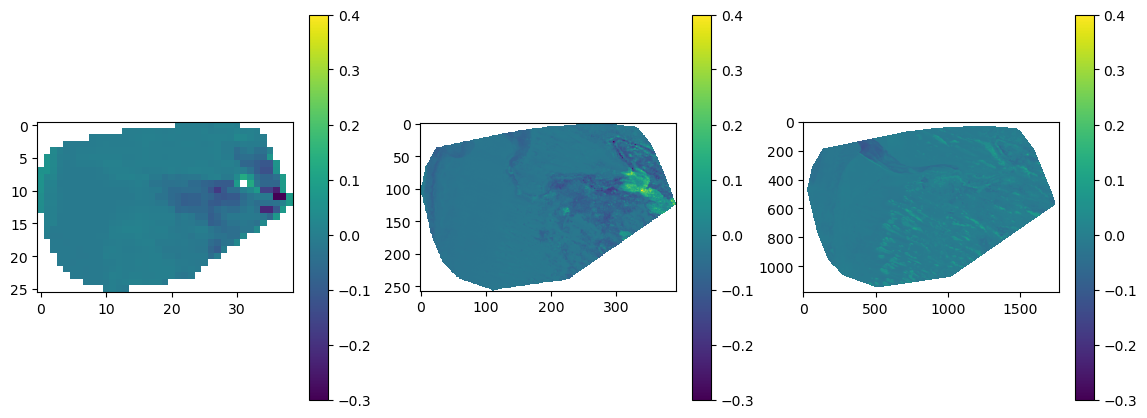

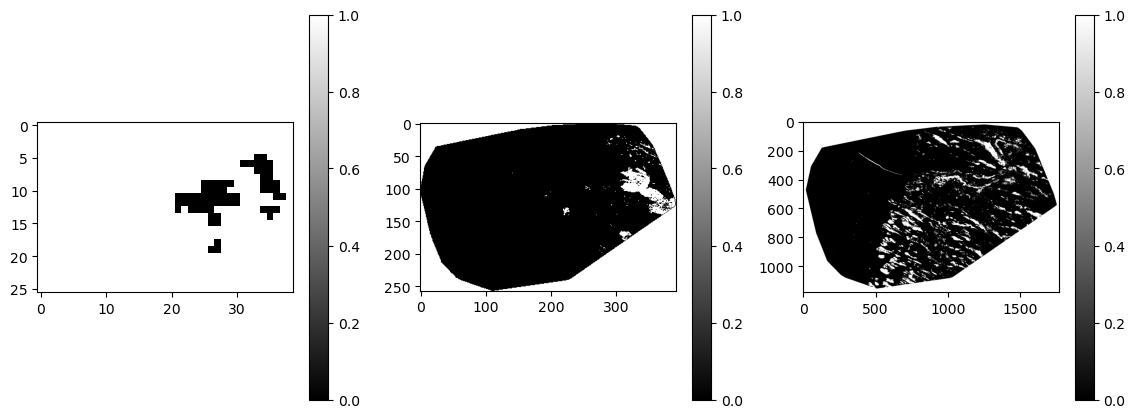

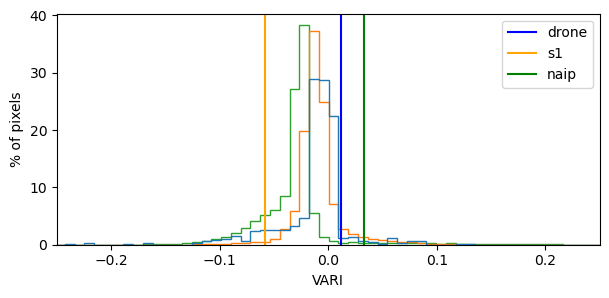

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_10080/3499913737.py:2: RuntimeWarning: invalid value encountered in divide
  vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + image_3_channel[:,:,2])


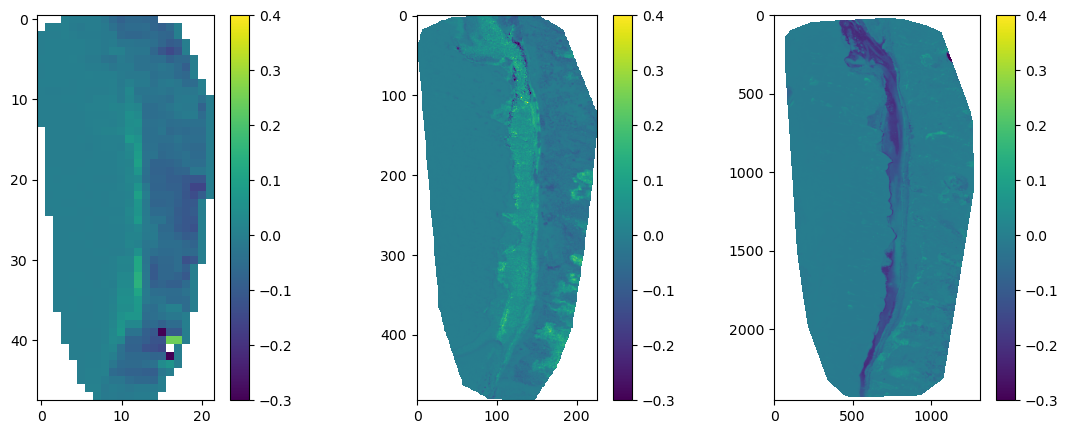

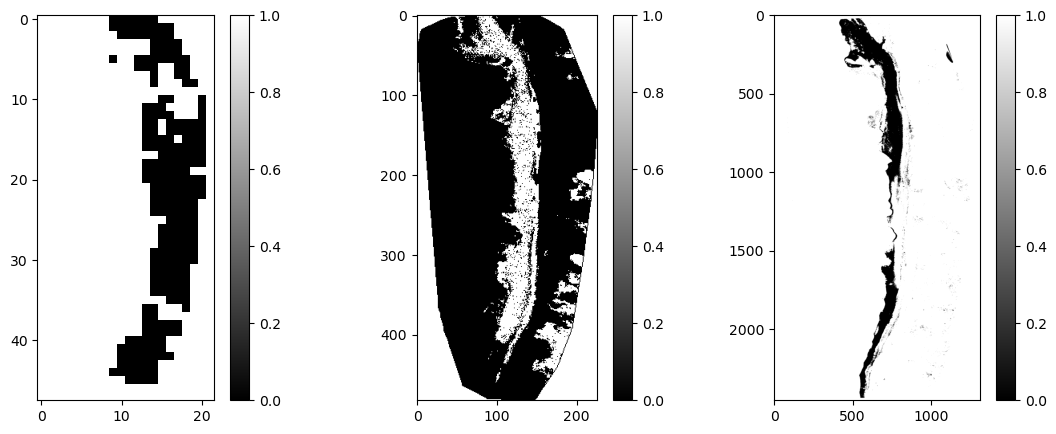

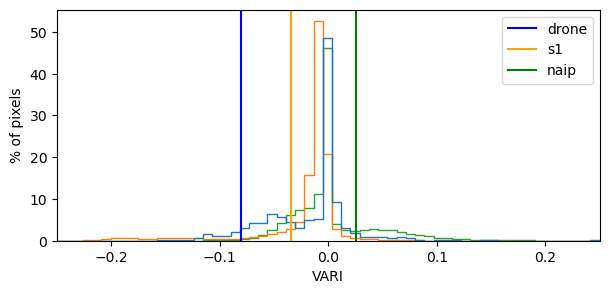

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_10080/3499913737.py:2: RuntimeWarning: invalid value encountered in divide
  vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + image_3_channel[:,:,2])


In [ ]:
out_ims = {}

for k,v in site_ims.items():
    
    # Calc VARI, resample by a factor of 4, interpolate 
    drone_vari_raw = vari(v['drone'])
    t = skimage.measure.block_reduce(drone_vari_raw, block_size=(4, 4), func=np.mean)
    x = np.arange(0, t.shape[1])
    y = np.arange(0, t.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(t)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    drone_vari = scipy.interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')
    
    # Calc VARI for other sensors 
    naip_vari = vari(v['naip'])
    s1_vari = vari(v['s1'])
    
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.imshow(s1_vari, vmin = -0.3, vmax = 0.4); plt.colorbar();
        
    plt.subplot(132)
    plt.imshow(naip_vari, vmin = -0.3, vmax = 0.4); plt.colorbar();
    
    plt.subplot(133)
    plt.imshow(drone_vari, vmin = -0.3, vmax = 0.4); plt.colorbar();
    
    # Get otsu's threshold 
    s1_thresh_val, s1_thresh_im = get_otsu_thresh(s1_vari)
    naip_thresh_val, naip_thresh_im = get_otsu_thresh(naip_vari)
    drone_thresh_val, drone_thresh_im = get_otsu_thresh(drone_vari)
    
    s1_thresh_im[np.isnan(s1_vari)] = np.nan
    naip_thresh_im[np.isnan(naip_vari)] = np.nan
    drone_thresh_im[np.isnan(drone_vari)] = np.nan

    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.imshow(s1_thresh_im, cmap=plt.cm.gray); plt.colorbar();
        
    plt.subplot(132)
    plt.imshow(naip_thresh_im, cmap=plt.cm.gray); plt.colorbar();
    
    plt.subplot(133)
    plt.imshow(drone_thresh_im, cmap=plt.cm.gray); plt.colorbar();
    
    plt.show()
    
    plt.figure(figsize = (7,3))
    plt.hist([s1_vari.flatten(),drone_vari.flatten(),naip_vari.flatten()], bins = 200, density = True,histtype=u'step')
    plt.axvline(drone_thresh_val, color = 'blue', label = 'drone')
    plt.axvline(s1_thresh_val, color = 'orange', label = 's1')
    plt.axvline(naip_thresh_val, color = 'green', label = 'naip')
    plt.xlim([-0.25, 0.25])
    plt.xlabel("VARI")
    plt.ylabel("% of pixels")
    plt.legend()
    plt.show()

    out_ims['drone'] = drone_vari
    out_ims['naip'] = naip_vari
    out_ims['s1'] = s1_vari

In [ ]:
from PIL import Image


In [ ]:
for k,v in site_ims.items():
    
    # Drone 
    r = v['drone'][:,:,0]
    g = v['drone'][:,:,1]
    b = v['drone'][:,:,2]
    
    drone_thresh_val_r, drone_thresh_im_r = get_otsu_thresh(r)
    drone_thresh_val_g, drone_thresh_im_g = get_otsu_thresh(g)
    drone_thresh_val_b, drone_thresh_im_b = get_otsu_thresh(b)
    
    print("drone Threshes")
    print(drone_thresh_val_r, drone_thresh_val_g, drone_thresh_val_b)
    
    # Naip 
    r = v['naip'][:,:,0]
    g = v['naip'][:,:,1]
    b = v['naip'][:,:,2]
    
    naip_thresh_val_r, naip_thresh_im_r = get_otsu_thresh(r)
    naip_thresh_val_g, naip_thresh_im_g = get_otsu_thresh(g)
    naip_thresh_val_b, naip_thresh_im_b = get_otsu_thresh(b)
    
    print("naip Threshes")
    print(naip_thresh_val_r, naip_thresh_val_g, naip_thresh_val_b)
    
    # S1
    r = v['s1'][:,:,0]
    g = v['s1'][:,:,1]
    b = v['s1'][:,:,2]
    
    s1_thresh_val_r, s1_thresh_im_r = get_otsu_thresh(r)
    s1_thresh_val_g, s1_thresh_im_g = get_otsu_thresh(g)
    s1_thresh_val_b, s1_thresh_im_b = get_otsu_thresh(b)
    
    print("S1 Threshes")
    print(s1_thresh_val_r, s1_thresh_val_g, s1_thresh_val_b)
    
    class_naip = np.nansum([naip_thresh_im_r, naip_thresh_im_g, naip_thresh_im_b],axis = 0).astype(float)
    class_drone = np.nansum([drone_thresh_im_r, drone_thresh_im_g, drone_thresh_im_b],axis = 0).astype(float)
    class_s1 = np.nansum([s1_thresh_im_r, s1_thresh_im_g, s1_thresh_im_b],axis = 0).astype(float)
    
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.imshow(class_drone, cmap = 'Reds_r', alpha = 1)
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(class_naip, cmap = 'Reds_r', alpha = 1)
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(class_s1, cmap = 'Reds_r', alpha = 1)
    plt.colorbar()
    plt.show()

In [ ]:
for k,v, in out_ims.items():
    np.save("../data/{}.npy".format(k),v)

In [ ]:


fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')
ax[1].set_xlim([-0.25,0.25])

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
cutoff_values = {'OsoFlacoRiver':{'drone':-0.025,'s1':-0.4,''}



In [ ]:
image.astype(float)[image.astype(float) == np.nan] = 0
plt.imshow(image); plt.colorbar()

In [ ]:


plt.figure(figsize = (7,3))
plt.hist((drone_vari.flatten()), bins = 150, label = 'drone', density = True,alpha = 0.25)
plt.axvline(np.nanpercentile((drone_vari.flatten()),15), color = 'blue', label = 'drone mean')
plt.hist((s1_vari.flatten()), bins = 25, label = 's1', density = True, alpha = 0.25)
plt.axvline(np.nanmean((s1_vari.flatten())), color = 'orange', label = 's1 mean')
plt.hist((naip_vari.flatten()), bins = 150, label = 'naip', density = True, alpha = 0.25)
plt.axvline(np.nanmean((naip_vari.flatten())), color = 'green', label = 'naip mean')
plt.xlim([-0.25, 0.25])
plt.legend()

In [ ]:
ddf = pd.DataFrame([drone_vari.flatten()]).T

In [ ]:
ddf = pd.DataFrame([drone_vari.flatten()]).T

ddf.columns = ['vari']
ddf = ddf.dropna()
ddf['sensor'] = 'drone'


In [ ]:
sdf = pd.DataFrame([s1_vari.flatten()]).T.dropna()
sdf.columns = ['vari']
sdf['sensor'] = 's1'

ndf = pd.DataFrame([naip_vari.flatten()]).T.dropna()
ndf.columns = ['vari']
ndf['sensor'] = 'naip'

In [ ]:
pldf = pd.concat([ddf,ndf,sdf])

In [ ]:
plt.figure(figsize = (8,3))
sns.histplot(pldf, x="vari", hue="sensor", element="step",kde = True, stat = 'probability', bins = 500)
# plt.xlim([0,50])
# plt.ylim([0,55])
plt.title("VARI histograms", size = 18)
plt.xlabel("VARI", size = 16)
plt.ylabel("Count", size = 16)
plt.show()


In [ ]:
s = pd.DataFrame([drone_vari.flatten(), s1_vari.flatten(), naip_vari.flatten()])

In [ ]:
odf = s.T
odf.columns = ['drone','s1','naip']

In [ ]:
plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="manual", hue="species", element="step", kde = True, bins = 20)
# plt.xlim([0,50])
# plt.ylim([0,55])
plt.title("Tape Measure", size = 18)
plt.xlabel("Manual Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()


In [ ]:
plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="manual", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,55])
plt.title("Tape Measure", size = 18)
plt.xlabel("Manual Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()

plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="app", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,50])
plt.title("Phone application", size = 18)
plt.xlabel("Mobile Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()


In [ ]:
t= skimage.measure.block_reduce(drone_vari, block_size=(4, 4), func=np.mean)

x = np.arange(0, t.shape[1])
y = np.arange(0, t.shape[0])
#mask invalid values
array = np.ma.masked_invalid(t)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

drone_vari_interp = scipy.interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')

In [ ]:
plt.imshow(GD1, vmin = -0.3, vmax = 0.4); plt.colorbar();

plt.show()

In [ ]:

s = pd.DataFrame([drone_vari.flatten(), s1_vari.flatten(), naip_vari.flatten()])

In [ ]:
[len(x) for x in [drone_vari.flatten(), s1_vari.flatten(), naip_vari.flatten()]]

In [ ]:


plt.figure(figsize = (7,3))
plt.hist((drone_vari.flatten()), bins = 150, label = 'drone hist', density = True,alpha = 0.25)
plt.axvline(np.nanpercentile((drone_vari.flatten()),15), color = 'blue', label = 'drone mean')
plt.hist((s1_vari.flatten()), bins = 150, label = 's1 hist', density = True, alpha = 0.25)
plt.axvline(np.nanmean((s1_vari.flatten())), color = 'orange', label = 's1 mean')
plt.hist((naip_vari.flatten()), bins = 150, label = 's1 naip', density = True, alpha = 0.25)
plt.axvline(np.nanmean((naip_vari.flatten())), color = 'green', label = 'naip mean')
plt.xlim([-0.25, 0.25])
plt.legend()

In [ ]:
plt.figure(figsize = (7,3))
plt.hist(normalize(drone_vari.flatten()), bins = 50, label = 'drone hist', density = True)
plt.axvline(np.nanmean(normalize(drone_vari.flatten())), color = 'blue', label = 'drone mean')
plt.hist(normalize(s1_vari.flatten()), bins = 50, label = 's1 hist', density = True)
plt.axvline(np.nanmean(normalize(s1_vari.flatten())), color = 'orange', label = 's1 mean')
plt.hist(normalize(naip_vari.flatten()), bins = 50, label = 's1 naip', density = True)
plt.axvline(np.nanmean(normalize(naip_vari.flatten())), color = 'green', label = 'naip mean')

plt.legend()

In [ ]:
im_dict['drone']

In [ ]:
# def classify_water(im):
#     e1 = ndi.binary_fill_holes(canny(im[:,:,0], sigma = 1))
#     e2 = ndi.binary_fill_holes(canny(im[:,:,1], sigma = 1))
#     e3 = ndi.binary_fill_holes(canny(im[:,:,2], sigma = 1))
    
#     probs = e1.astype(int)+e2.astype(int)+e3.astype(int)
    
#     return normalize(probs)




In [ ]:
# plt.subplot(111)
# plt.imshow(classify_water(site_ims['KanabDam']['drone'])); plt.colorbar()

In [ ]:
# for k,v in site_ims.items():
#     print(k)
#     drone_class = classify_water(v['drone'])
#     naip_class = classify_water(v['naip'])
#     s1_class = classify_water(v['s1'])
    
#     plt.figure(figsize=(14,5))
#     plt.subplot(131)
#     plt.imshow(s1_class); plt.colorbar();
        
#     plt.subplot(132)
#     plt.imshow(naip_class); plt.colorbar();
    
#     plt.subplot(133)
#     plt.imshow(drone_class); plt.colorbar();
    
#     plt.show()